In [1]:
import uproot
import numpy as np
import numba
import matplotlib.pyplot as plt
import hist as hephist
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
from sklearn.gaussian_process import GaussianProcessRegressor 
import scipy.optimize
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
import pandas as pd
import scipy.stats
from scipy import integrate as intg 
from scipy.integrate import trapz, simps, quad
import math
from uncertainties import ufloat
import seaborn as sns
#sns.set_theme()
#df = sns.load_dataset("penguins")


#%matplotlib inline
%matplotlib widget

In [2]:
file = uproot.open("../../root_files/merged_RS67_3089LD2.root")
result_tree = file['result']
result_mix_tree = file['result_mix']
result_branches = result_tree.arrays()
result_mix_branches = result_mix_tree.arrays()


#MonteCarlo files
jpsi_file = uproot.open("../../root_files/mc_jpsi_LD2_M027_S001_messy_occ_pTxFweight_v2.root")
#jpsi_file = uproot.open("../../root_files/mc_jpsi_dump_M026_S002_messy_all_0_mix1_pT_D.root")
jpsi_tree = jpsi_file['Tree']
jpsi_branches = jpsi_tree.arrays()

psiprime_file = uproot.open("../../root_files/mc_psiprime_LD2_M027_S001_messy_occ_pTxFweight_v2.root")
#psiprime_file = uproot.open("../../root_files/mc_psiprime_dump_M026_S002_messy_all_0_mix1_pT_D.root")
psiprime_tree = psiprime_file['Tree']
psiprime_branches = psiprime_tree.arrays()





In [3]:
df_real = result_tree.arrays(library="pd") #to get as pandas data frame
df_real.head()

df_mix = result_mix_tree.arrays(library="pd")
df_mix.head()


df_jpsi = jpsi_tree.arrays(library="pd")
df_psip = psiprime_tree.arrays(library="pd")
df_jpsi.head()

,runID,spillID,eventID,dimuonID,mass,px1,py1,pz1,px2,py2,...,mxT,mxF,mdpx,mdpy,mdpz,sigWeight,D1,D2,D3,ReWeight
0,1.0,1.0,27.0,1.0,2.720205,-1.626641,-0.785197,43.769295,0.881755,0.004412,...,0.054132,0.824789,0.212206,-0.329175,101.290558,434.299164,221,148,122,1060.904419
1,1.0,1.0,27.0,2.0,3.078017,-1.322264,-0.651057,43.797493,1.530952,0.483032,...,0.054132,0.824789,0.212206,-0.329175,101.290558,434.299164,221,148,122,1060.904419
2,1.0,1.0,28.0,3.0,3.208771,-1.689938,0.168840,60.717159,1.497082,-0.088600,...,0.052288,0.874601,-0.435145,-0.291158,106.794304,223.422028,85,93,85,467.727875
3,1.0,1.0,31.0,4.0,3.168767,-1.215392,-0.929872,52.555119,0.920419,1.381949,...,0.048230,0.986413,-0.196134,0.610485,119.158180,43.606625,77,94,55,47.819218
4,1.0,1.0,33.0,5.0,2.987077,-1.318314,-0.735957,50.749680,1.569308,-0.569120,...,0.073255,0.673224,0.221998,-1.359133,86.165558,2582.398438,259,210,130,1295.462769


# Cut Functions for LD2 Target Position

In [4]:
#----------------Data----------------------
def PosTrk_cut(df_p):

    ptrk_chisq_mask = (df_p['chisq1_target']<15.) &\
                        (df_p['chisq1_target'] < (1.5*df_p['chisq1_upstream'])) &\
                        (df_p['chisq1_target'] < (1.5*df_p['chisq1_dump'])) &\
                        (df_p['nHits1'] > 13) &\
                        ((df_p['chisq1']/(df_p['nHits1']-5.)) < 12.)
    
    ptrk_mom_mask = (df_p['pz1_st1'] > 9.) &\
                    (df_p['pz1_st1'] < 75.) &\
                    (np.fabs(np.fabs(df_p['px1_st1']-df_p['px1_st3']) - 0.416)<0.008) &\
                    (np.fabs(df_p['py1_st1']-df_p['py1_st3']) < 0.008) &\
                    (np.fabs(df_p['pz1_st1']-df_p['pz1_st3']) < 0.08) &\
                    (np.fabs(df_p['py1_st1'])>0.02)

    ptrk_position_mask = ((df_p['y1_st1']*df_p['y1_st3'])>0) &\
                    ((df_p['y1_st1']/df_p['y1_st3'])<1.) &\
                    (df_p['z1_v'] < -5.) & (df_p['z1_v'] > -320.) &\
                    (((df_p['x1_t'])**2) + ((df_p['y1_t']-1.6)**2) < 320.) & \
                    ((((df_p['x1_d'])**2) + ((df_p['y1_d']-1.6)**2)) < 1100.) &\
                    ((((df_p['x1_d'])**2) + ((df_p['y1_d']-1.6)**2)) > 8.) 

    return (ptrk_chisq_mask) & (ptrk_mom_mask) & (ptrk_position_mask)
    
def NegTrk_cut(df_n):
    
    ntrk_chisq_mask = (df_n['chisq2_target']<15.) &\
                    (df_n['chisq2_target'] < (1.5*df_n['chisq2_upstream'])) &\
                    (df_n['chisq2_target'] < (1.5*df_n['chisq2_dump'])) &\
                    (df_n['nHits2'] > 13) &\
                    ((df_n['chisq2'] /(df_n['nHits2']-5)) < 12.)

    ntrk_mom_mask = (df_n['pz2_st1'] > 9.) & (df_n['pz2_st1'] < 75.) & \
                    (np.fabs(np.fabs(df_n['px2_st1']-df_n['px2_st3']) - 0.416)<0.008) & \
                    (np.fabs(df_n['py2_st1']-df_n['py2_st3']) < 0.008) & \
                    (np.fabs(df_n['pz2_st1']-df_n['pz2_st3']) < 0.08) & \
                    (np.fabs(df_n['py2_st1'])>0.02)

    ntrk_position_mask = ((df_n['y2_st1']*df_n['y2_st3'])>0) &\
                    ((df_n['y2_st1']/df_n['y2_st3'])<1) &\
                    (df_n['z2_v'] < -5) & (df_n['z2_v'] > -320) & \
                    ((((df_n['x2_t'])**2) + ((df_n['y2_t']-1.6)**2)) < 320.) & \
                    ((((df_n['x2_d'])**2) + ((df_n['y2_d']-1.6)**2)) < 1100.) &\
                    ((((df_n['x2_d'])**2) + ((df_n['y2_d']-1.6)**2)) > 8.)
    
    return (ntrk_chisq_mask) & (ntrk_mom_mask) & (ntrk_position_mask)




In [5]:
def dim_cut(df_d): 
    vtx_mask =  (np.fabs(df_d['dx']) < 0.25) & (np.fabs(df_d['dy']-1.6) < 0.22) &\
                (((df_d['dx']*df_d['dx'])+((df_d['dy']-1.6)*(df_d['dy']-1.6))<0.06) &\
                 df_d['dz'] > -280) & (df_d['dz'] < -5)
    
    mom_mask = (np.fabs(df_d['dpx']) < 1.8) &\
                (np.fabs(df_d['dpy']) < 2.) &\
                (((df_d['dpx']*df_d['dpx']) + (df_d['dpy']*df_d['dpy']))<5.) &\
                (df_d['dpz'] > 38) & (df_d['dpz'] < 116)

    both_trk_mask = (np.fabs(df_d['trackSeparation']) < 270.) &\
                    ((df_d['nHits1']+df_d['nHits2'])>29) &\
                    ((df_d['y1_st3']*df_d['y2_st3'])<0) &\
                    (df_d['nHits1St1']+df_d['nHits2St1'] >8) &\
                    (np.fabs(df_d['x1_st1']+df_d['x2_st1'])<42)

    chisq_mask = (df_d['chisq_dimuon'] < 18.) &\
                 (np.fabs((df_d['chisq1_target']+df_d['chisq2_target']-df_d['chisq_dimuon'])) <2.)

    return (vtx_mask) & (mom_mask) & (both_trk_mask) & (chisq_mask)
    
def Physics_cut(df_ph):
    phycs_mask =  (np.fabs(df_ph['costh'])<0.5) &\
                    (df_ph['xF'] > -0.1) & (df_ph['xF'] < 0.95) &\
                    (df_ph['xT'] > 0.005) & (df_ph['xT']<0.55) &\
                    (df_ph['mass']<8.8)
    return phycs_mask
    
    
def Occu_cut(df_):                   
    occu_mask = (df_['D1']<400) & (df_['D2']<400) & ((df_['D3'])<400) &\
            ((df_['D1']+df_['D2'] + df_['D3']) <1000) &\
            (df_['pot_p00']<80000.) & (df_['pot_p00']>0.)
    return occu_mask

In [6]:
real_PosTrk_cut = PosTrk_cut(df_real)
real_NegTrk_cut = NegTrk_cut(df_real)
real_Physics_cut = Physics_cut(df_real)
real_Occu_cut = Occu_cut(df_real)
real_dim_cut = dim_cut(df_real)

real_data_cut = (real_PosTrk_cut) & (real_NegTrk_cut) & (real_Physics_cut) & (real_Occu_cut) & (real_dim_cut)


In [7]:
mix_PosTrk_cut = PosTrk_cut(df_mix)
mix_NegTrk_cut = NegTrk_cut(df_mix)
mix_Physics_cut = Physics_cut(df_mix)
mix_Occu_cut = Occu_cut(df_mix)
mix_dim_cut = dim_cut(df_mix)

mix_data_cut = (mix_PosTrk_cut) & (mix_NegTrk_cut) & (mix_Physics_cut) & (mix_Occu_cut) & (mix_dim_cut)



In [8]:
real_mass=df_real['mass'][real_data_cut]
mix_mass=df_mix['mass'][mix_data_cut]




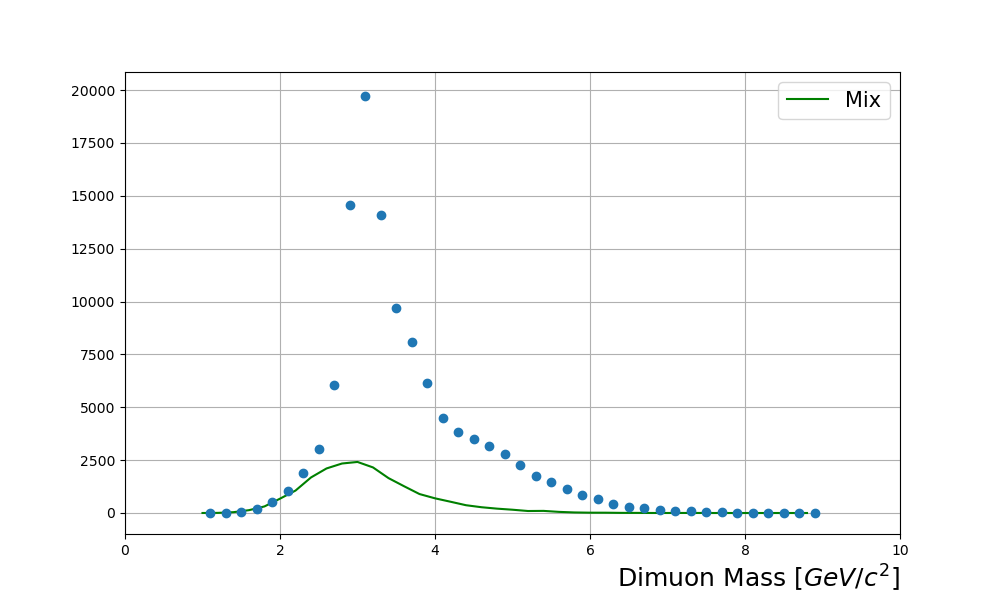

Mix number:  19285.999999999993
Real number:  112346.99999999997
40


In [9]:
xmin = 1. # GeV
xmax = 9. # GeV
step_size = 0.2 # GeV
    
bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values
data_x,_ = np.histogram(real_mass, 
                           bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt(data_x) # statistical error on the data

mix_x,_ = np.histogram(mix_mass, 
                           bins=bin_edges ) # histogram the data
mix_x_errors = np.sqrt(mix_x) # statistical error on the data


fig = plt.figure(figsize=(10,6))
plt.plot(bin_edges[0:-1], mix_x,label="Mix",color="green")
plt.errorbar(x=bin_centres, y = data_x, yerr=data_x_errors, fmt='o')
#plt.yscale('log')
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 
plt.grid(True)
plt.legend(loc='upper right')
plt.legend(prop={'size':15})
plt.xlim(right=10.) #xmax is your value
plt.xlim(left=0.) #xmin is your value
#plt.yscale('log')
plt.show()

print("Mix number: ", np.sum(mix_x * np.diff(bin_edges))/0.2)
print("Real number: ", np.sum(data_x * np.diff(bin_edges))/0.2)
mix_x.size
print(bin_centres.size)

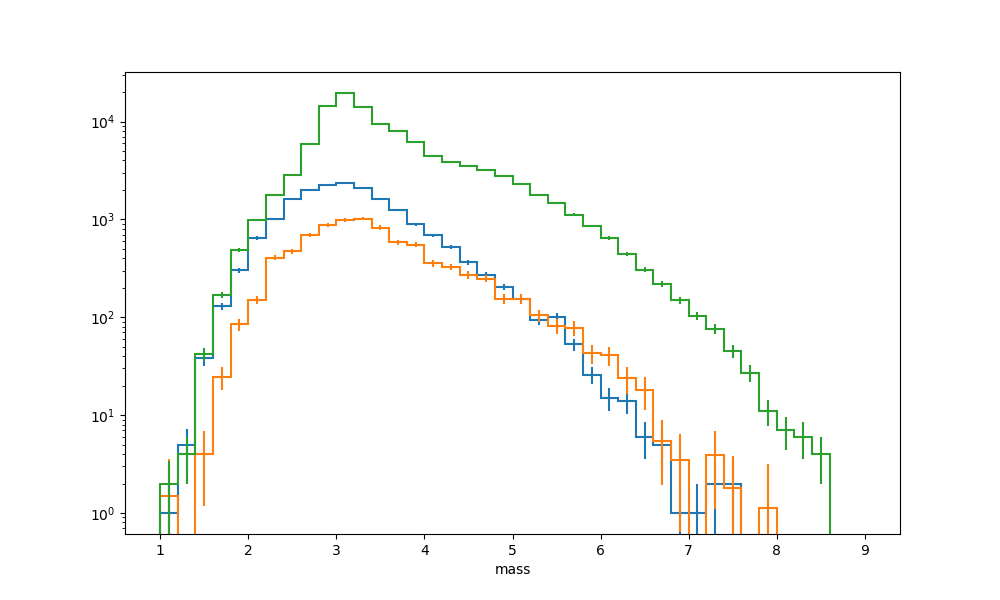

In [10]:
fig = plt.figure(figsize=(10,6))
uiuc_file = uproot.open("../../root_files/massfit_rs67_LD2.root")
uiuc_file["nmsu_mix"].to_hist().plot()
uiuc_file["hist_flask"].to_hist().plot()
uiuc_file["nmsu_real"].to_hist().plot()
plt.yscale("log")
plt.show()


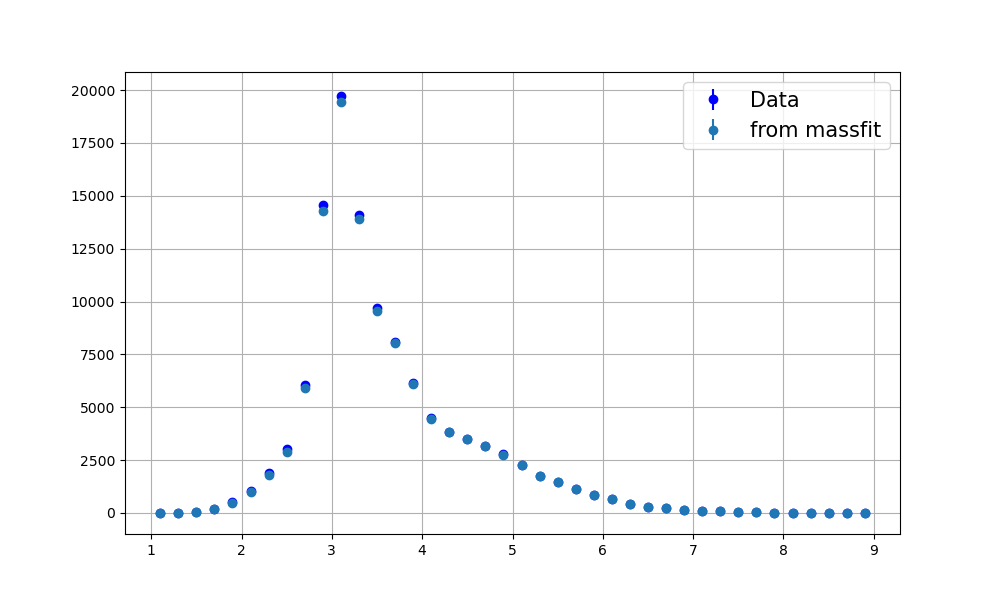

In [11]:
fig1 = plt.figure(figsize=(10,6))

real_x = uiuc_file["nmsu_real"].values()
real_x_err = uiuc_file["nmsu_real"].errors()
plt.errorbar(x=bin_centres, y = data_x, yerr=data_x_errors, fmt='o', color="blue",label="Data")
plt.errorbar(x=bin_centres, y = real_x, yerr=real_x_err, fmt='o', label="from massfit")

 
plt.grid(True)
plt.legend(loc='upper right')
plt.legend(prop={'size':15})
#plt.ylim(bottom=1.)
#plt.yscale('log')
plt.show()

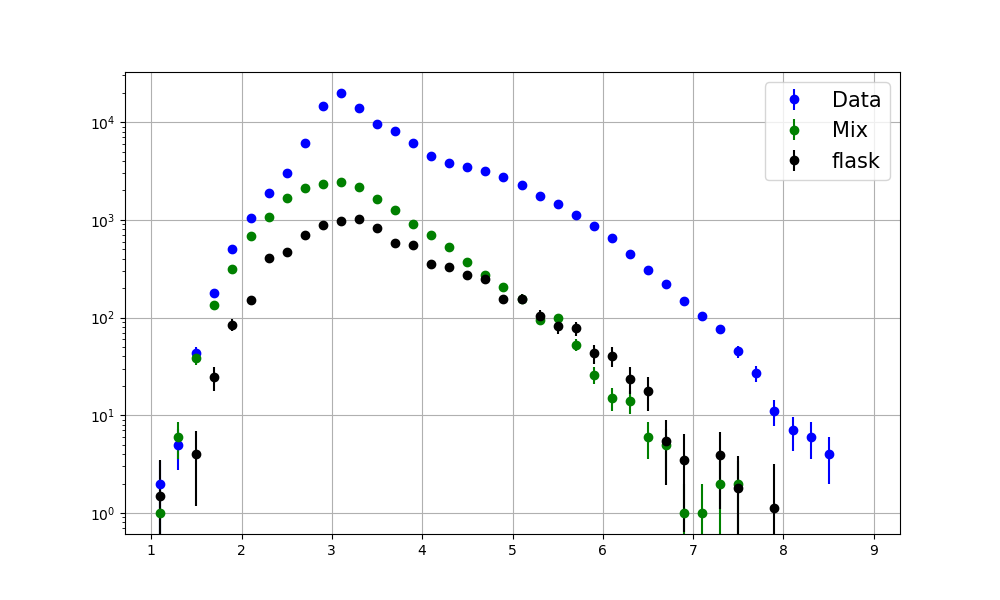

In [12]:
fig1 = plt.figure(figsize=(10,6))

flask_x = uiuc_file["hist_flask"].values()
flask_x_err = uiuc_file["hist_flask"].errors()
plt.errorbar(x=bin_centres, y = data_x, yerr=data_x_errors, fmt='o', color="blue",label="Data")
plt.errorbar(x=bin_centres, y = mix_x,yerr = mix_x_errors , color="green", fmt = 'o',label="Mix")

plt.errorbar(x=bin_centres, y = flask_x, yerr=flask_x_err, fmt='o', color="black", label="flask")

 
plt.grid(True)
plt.legend(loc='upper right')
plt.legend(prop={'size':15})
#plt.ylim(bottom=1.)
plt.yscale('log')
plt.show()

## Choosing Singal

In [13]:
#signal_x = data_x - mix_x - flask_x
#signal_x = data_x - mix_x
signal_x = data_x

#signal_x_errors = np.sqrt(np.square(data_x_errors)+np.square(mix_x_errors)+np.square(flask_x_err)) 
#signal_x_errors = np.sqrt(np.square(data_x_errors)+np.square(mix_x_errors))
signal_x_errors = data_x_errors 

## Choose Side Bands

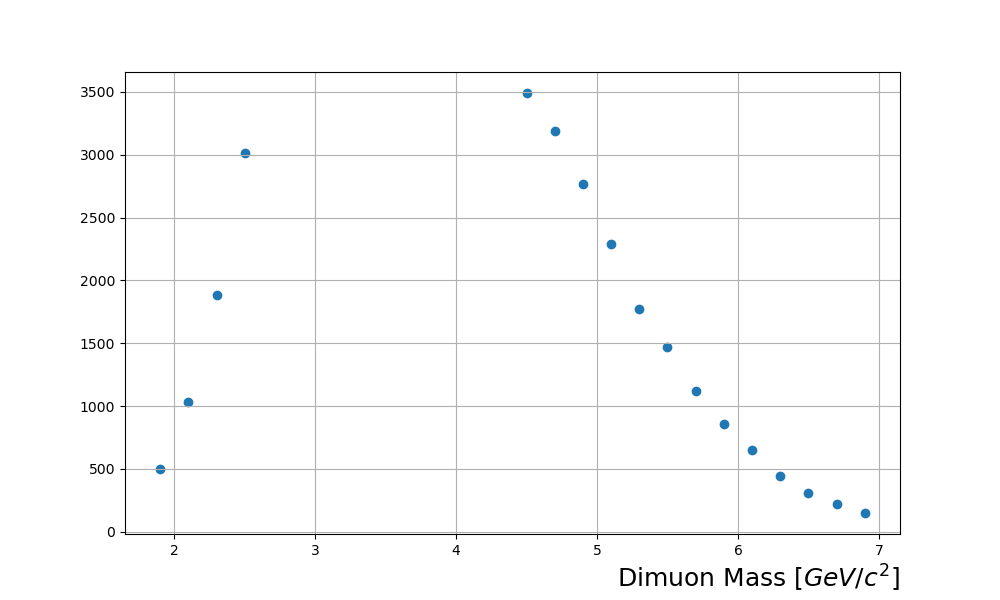

In [14]:
sideband = np.array([1.8, 2.5, 4.5, 7.])

data=np.column_stack((np.array(bin_centres),np.array(signal_x), np.array(signal_x_errors)))

mask = (((sideband[0] <= data[:,0]) & (data[:,0] <= sideband[1])) | ((sideband[2] <= data[:,0]) & (data[:,0] <= sideband[3])))
data_train = data[mask]
fig = plt.figure(figsize=(10,6))
train_axes = plt.gca()
X_train=data_train[:,0]
Y_train=data_train[:,1]
Y_train_error=data_train[:,2]

train_axes.scatter(X_train,Y_train)
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                       x=1, horizontalalignment='right', fontsize=18 ) 



plt.grid(True)
plt.show()

## Implementing Gaussian Process

In [15]:
sideband_kernel = C(5000.0, (1e-10, 1e15))*RBF(length_scale=5, length_scale_bounds=(1e-4, 1e15))
#sideband_kernel = C(50000, (1e-10, 1e25))*RBF(length_scale=5, length_scale_bounds=(1e-4, 1e15))

gaussian_process = GaussianProcessRegressor(kernel=sideband_kernel, alpha=Y_train_error**2, n_restarts_optimizer=500)
#gaussian_process = GaussianProcessRegressor(kernel=sideband_kernel, alpha=Y_train_error**2, n_restarts_optimizer=500)


gaussian_process.fit(np.atleast_2d(X_train).T, Y_train)
gaussian_process.kernel_

/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


2.31e+03**2 * RBF(length_scale=0.847)

In [16]:
f"Log-likelihood: {gaussian_process.log_marginal_likelihood(gaussian_process.kernel_.theta):.3f}"

'Log-likelihood: -114.303'

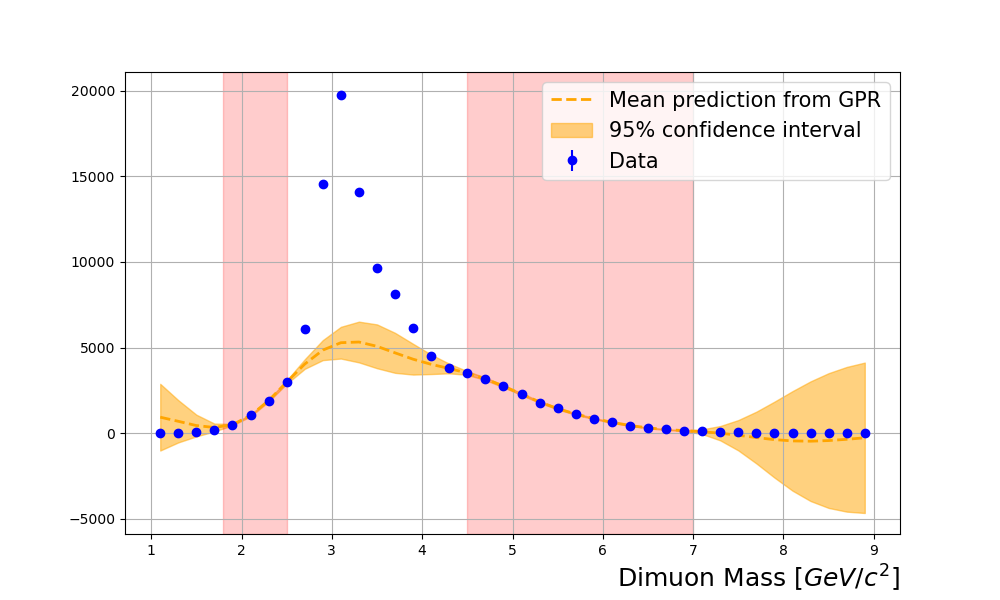

In [17]:
Y_pred, sigma = gaussian_process.predict(np.atleast_2d(data[:, 0]).T, return_std=True)
Y_pred, cov_matrix = gaussian_process.predict(np.atleast_2d(data[:, 0]).T, return_cov=True)

sigma2 = np.sum(cov_matrix, axis=0)
gpr_error = np.sqrt(abs(sigma2))
#gpr_error = sigma

fig = plt.figure(figsize=(10,6))

plt.errorbar(x=bin_centres, y = signal_x, yerr=signal_x_errors, fmt='o', color="blue",label="Data")

pred_axes = plt.gca()
pred_axes.plot(data[:,0],Y_pred, label="Mean prediction from GPR",color='orange',linestyle='--',linewidth=2)

pred_axes.fill_between(
    data[:,0].ravel(),
    Y_pred - 1.96 * sigma,
    Y_pred + 1.96 * sigma,
    alpha=0.5,
    label=r"95% confidence interval",
    color='orange'
)
plt.legend()
plt.legend(prop={'size':15})
plt.xticks(np.arange(xmin, xmax+1, 1.0))
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 
plt.axvspan(sideband[0], sideband[1], alpha=0.2, color='red')
plt.axvspan(sideband[2], sideband[3], alpha=0.2, color='red')
#plt.ylim(bottom=-20000.0)
#plt.yticks([])#Turn off the Y-axis values
#plt.xticks([])#Turn off the Y-axis values
plt.grid(True)
plt.show()


## Extracting JPsi and Psi'

In [18]:
peaks_signal=signal_x-Y_pred
peaks_signal_error = np.sqrt(np.square(signal_x_errors)+np.square(gpr_error))

### Double Gaussian Function

In [19]:
from lmfit.models import ExponentialModel, GaussianModel
from lmfit import Parameters, fit_report, minimize

x=bin_centres[5:20]
y=peaks_signal[5:20]
y_err=peaks_signal_error[5:20]


#print(y)
gauss1 = GaussianModel(prefix='g1_')
pars=(gauss1.make_params())

pars['g1_center'].set(value=3.1, min=1.4, max=4.0)
pars['g1_sigma'].set(value=0.24, min=0.1)
pars['g1_amplitude'].set(value=1000, min=10)


gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

pars['g2_center'].set(value=3.5, min=3., max=4.2)
pars['g2_sigma'].set(value=0.24, min=0.1)
pars['g2_amplitude'].set(value=100, min=0.1)   

 

mod = gauss1 + gauss2  #exp_mod

def gaussian(x, amp, cen, wid):
    return amp/(wid*np.sqrt(math.pi*2)) * np.exp(-(x-cen)**2 / (2*wid**2))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 15
    # variables        = 6
    chi-square         = 0.25960321
    reduced chi-square = 0.02884480
    Akaike info crit   = -48.8497670
    Bayesian info crit = -44.6014658
[[Variables]]
    g1_amplitude:  6284.04707 +/- 460.650875 (7.33%) (init = 1000)
    g1_center:     3.06011008 +/- 0.00823351 (0.27%) (init = 3.1)
    g1_sigma:      0.18287545 +/- 0.00469979 (2.57%) (init = 0.24)
    g1_fwhm:       0.43063878 +/- 0.01106716 (2.57%) == '2.3548200*g1_sigma'
    g1_height:     13708.6314 +/- 713.490547 (5.20%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:  2803.62650 +/- 477.398655 (17.03%) (init = 100)
    g2_center:     3.53650062 +/- 0.05642847 (1.60%) (init = 3.5)
    g2_sigma:      0.27848739 +/- 0.03436374 (12.34%) (init = 0.24)
    g2_fwhm:       0.65578767 +/- 0.08092042 (12.34%) == '2.3548200*g2_sigma'
    g2_height:     4016.28676 +/- 286.475336 (7

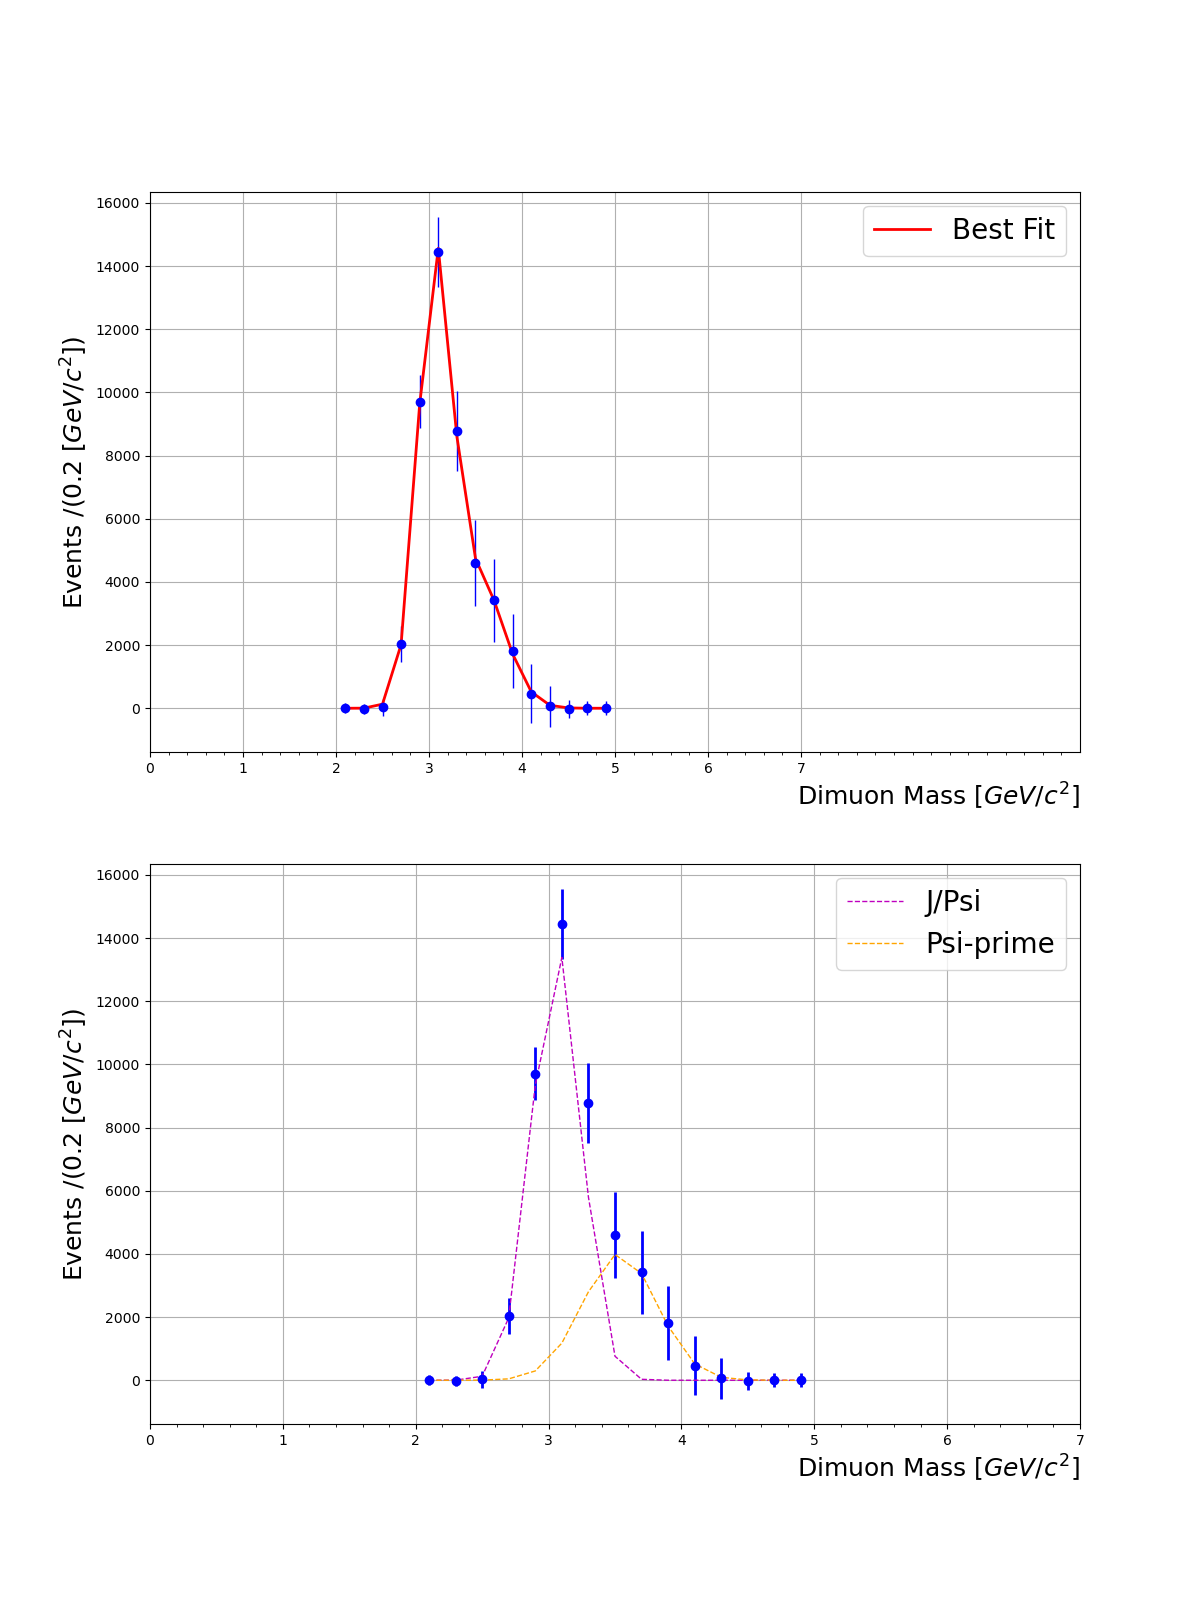

-----------------------------------
Parameter    Value       Stderr
g1_amplitude  6284.04707   460.65087
g1_center     3.06011     0.00823
g1_sigma     0.18288     0.00470
g1_fwhm     0.43064     0.01107
g1_height 13708.63141   713.49055
g2_amplitude  2803.62650   477.39865
g2_center     3.53650     0.05643
g2_sigma     0.27849     0.03436
g2_fwhm     0.65579     0.08092
g2_height  4016.28676   286.47534
-------------Integrals----------------------
6338.8471989086237954
2803.7340065937314648


In [20]:
init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x, weights=(1.0/(y_err)))
# Giving weights to Model.fit changes the array to minimize from (data-fit) to (data-fit)*weights


print(fit_report(out))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))

axes[0].errorbar(x,y,yerr=y_err,linewidth=1,color="blue",fmt='o')
axes[0].plot(x, out.best_fit, '-', label='Best Fit',linewidth=2,color="red")
axes[0].legend()

comps = out.eval_components(x=x)

axes[1].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
axes[1].plot(x, comps['g1_'], '--', label='J/Psi',linewidth=1,color="m")
axes[1].plot(x, comps['g2_'], '--', label='Psi-prime',linewidth=1, color="orange")
axes[1].legend()

axes[0].grid(True)
axes[0].legend(loc='upper right')
axes[0].legend(prop={'size':20})
axes[0].set_xticks(np.arange(0, 8, 1.0))
axes[0].xaxis.set_minor_locator( AutoMinorLocator() )
axes[0].set_xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 

axes[0].set_ylabel('Events /(0.2 $[GeV/c^2])$',
                        fontsize=18 ) 

axes[0].set_xlim(right=10.) #xmax is your value
axes[0].set_xlim(left=0.) #xmin is your value


axes[1].grid(True)
axes[1].legend(loc='upper right')
axes[1].legend(prop={'size':20})
#axes[1].set_xticks(np.arange(xmin, xmax+1, 1.0))
axes[1].set_xticks(np.arange(0, 8, 1.0))
axes[1].xaxis.set_minor_locator( AutoMinorLocator() )


axes[1].set_ylabel('Events /(0.2 $[GeV/c^2])$',
                        fontsize=18 ) 
axes[1].set_xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 

#axes[1].set_yscale('log')
plt.show()
#fig.savefig('plot/double_fit.svg', format='svg', dpi=1200)


print('-----------------------------------')
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')


#plt.errorbar(x,y,y_err, fmt="b.")
print('-------------Integrals----------------------')
print('{:18.16f}'.format(simps(comps['g1_'], x)))
print('{:18.16f}'.format(simps(comps['g2_'], x)))


### Pdf of JPsi and Psi' from GMC

In [21]:
jpsi_PosTrk_cut = PosTrk_cut(df_jpsi)
jpsi_NegTrk_cut = NegTrk_cut(df_jpsi)
jpsi_Physics_cut = Physics_cut(df_jpsi)
jpsi_Occu_cut = (df_jpsi['D1']<400) & (df_jpsi['D2']<400) & ((df_jpsi['D3'])<400) &\
            ((df_jpsi['D1']+df_jpsi['D2'] + df_jpsi['D3']) <1000)
jpsi_dim_cut = dim_cut(df_jpsi)

jpsi_mc_cut = (jpsi_PosTrk_cut) & (jpsi_NegTrk_cut) & (jpsi_Physics_cut) & (jpsi_Occu_cut) & (jpsi_dim_cut)


# jpsi_PosTrk_cut = Dump_PosTrk_cut(df_jpsi)
# jpsi_NegTrk_cut =Dump_NegTrk_cut(df_jpsi)
# jpsi_Physics_cut = Dump_Physics_cut(df_jpsi)
# jpsi_Occu_cut = (df_jpsi['D1']<400) & (df_jpsi['D2']<400) & ((df_jpsi['D3'])<400) &\
#             ((df_jpsi['D1']+df_jpsi['D2'] + df_jpsi['D3']) <1000)
# jpsi_dim_cut = Dump_dim_cut(df_jpsi)

# jpsi_mc_cut = (jpsi_PosTrk_cut) & (jpsi_NegTrk_cut) & (jpsi_Physics_cut)  & (jpsi_dim_cut)

In [22]:
psip_PosTrk_cut = PosTrk_cut(df_psip)
psip_NegTrk_cut = NegTrk_cut(df_psip)
psip_Physics_cut = Physics_cut(df_psip)
psip_Occu_cut = (df_psip['D1']<400) & (df_psip['D2']<400) & ((df_psip['D3'])<400) &\
            ((df_psip['D1']+df_psip['D2'] + df_psip['D3']) <1000)
psip_dim_cut = dim_cut(df_psip)

psip_mc_cut = (psip_PosTrk_cut) & (psip_NegTrk_cut) & (psip_Physics_cut) & (psip_Occu_cut) & (psip_dim_cut)

In [23]:
jpsi_mass=0.99*df_jpsi['mass'][jpsi_mc_cut]
psip_mass=0.99*df_psip['mass'][psip_mc_cut]

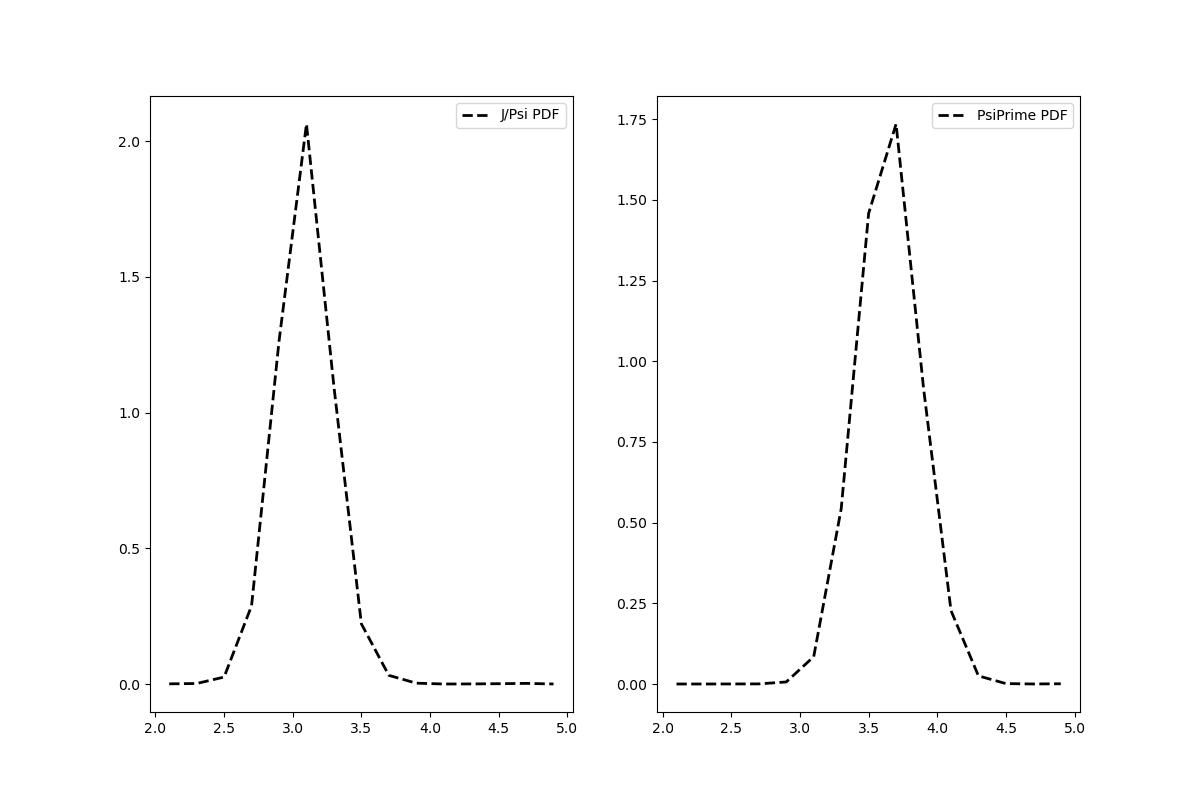

In [24]:
#making pdf for j/psi and psi'


jpsi_hist = np.histogram(jpsi_mass, weights= jpsi_branches['sigWeight'][jpsi_mc_cut], range=(1.,9.), 
                           bins=40)

jpsi_dist = scipy.stats.rv_histogram(jpsi_hist)

psiprime_hist = np.histogram(psip_mass, weights=psiprime_branches['sigWeight'][psip_mc_cut], range=(1.,9.),
                            bins=40) 
psiprime_dist = scipy.stats.rv_histogram(psiprime_hist)
#fig = plt.figure(figsize=(10,6))
#sns.kdeplot(jpsi_mass, weights = df_jpsi['sigWeight'][jpsi_mc_cut], bw_adjust =2)




fig, axes1 = plt.subplots(1, 2, figsize=(12, 8))
axes1[0].plot(x, jpsi_dist.pdf(x), '--', label='J/Psi PDF',linewidth=2,color="black")
axes1[0].legend()
axes1[1].plot(x, psiprime_dist.pdf(x), '--', label='PsiPrime PDF',linewidth=2,color="black")
axes1[1].legend()
plt.show()
def jpsi_pdf(x, amp):
    #return (amp*jpsi_dist.pdf(x)/jpsi_hist[0].sum())
    return (amp*jpsi_dist.pdf(x))
def psiprime_pdf(x, amp):
    #return (amp*psiprime_dist.pdf(x)/psiprime_hist[0].sum())
    return (amp*psiprime_dist.pdf(x))       

In [25]:
from lmfit import Model


jpsi_model = Model(jpsi_pdf, prefix='jpsi_')
pars=(jpsi_model.make_params())
pars['jpsi_amp'].set(value=1000)


psip_model = Model(psiprime_pdf, prefix='psip_')
pars.update(psip_model.make_params())
pars['psip_amp'].set(value=100)   

model_peaks = jpsi_model + psip_model

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 15
    # variables        = 2
    chi-square         = 1.24687511
    reduced chi-square = 0.09591347
    Akaike info crit   = -33.3111454
    Bayesian info crit = -31.8950450
[[Variables]]
    jpsi_amp:  7182.01409 +/- 120.748619 (1.68%) (init = 1000)
    psip_amp:  1912.53539 +/- 161.654539 (8.45%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(jpsi_amp, psip_amp) = -0.145


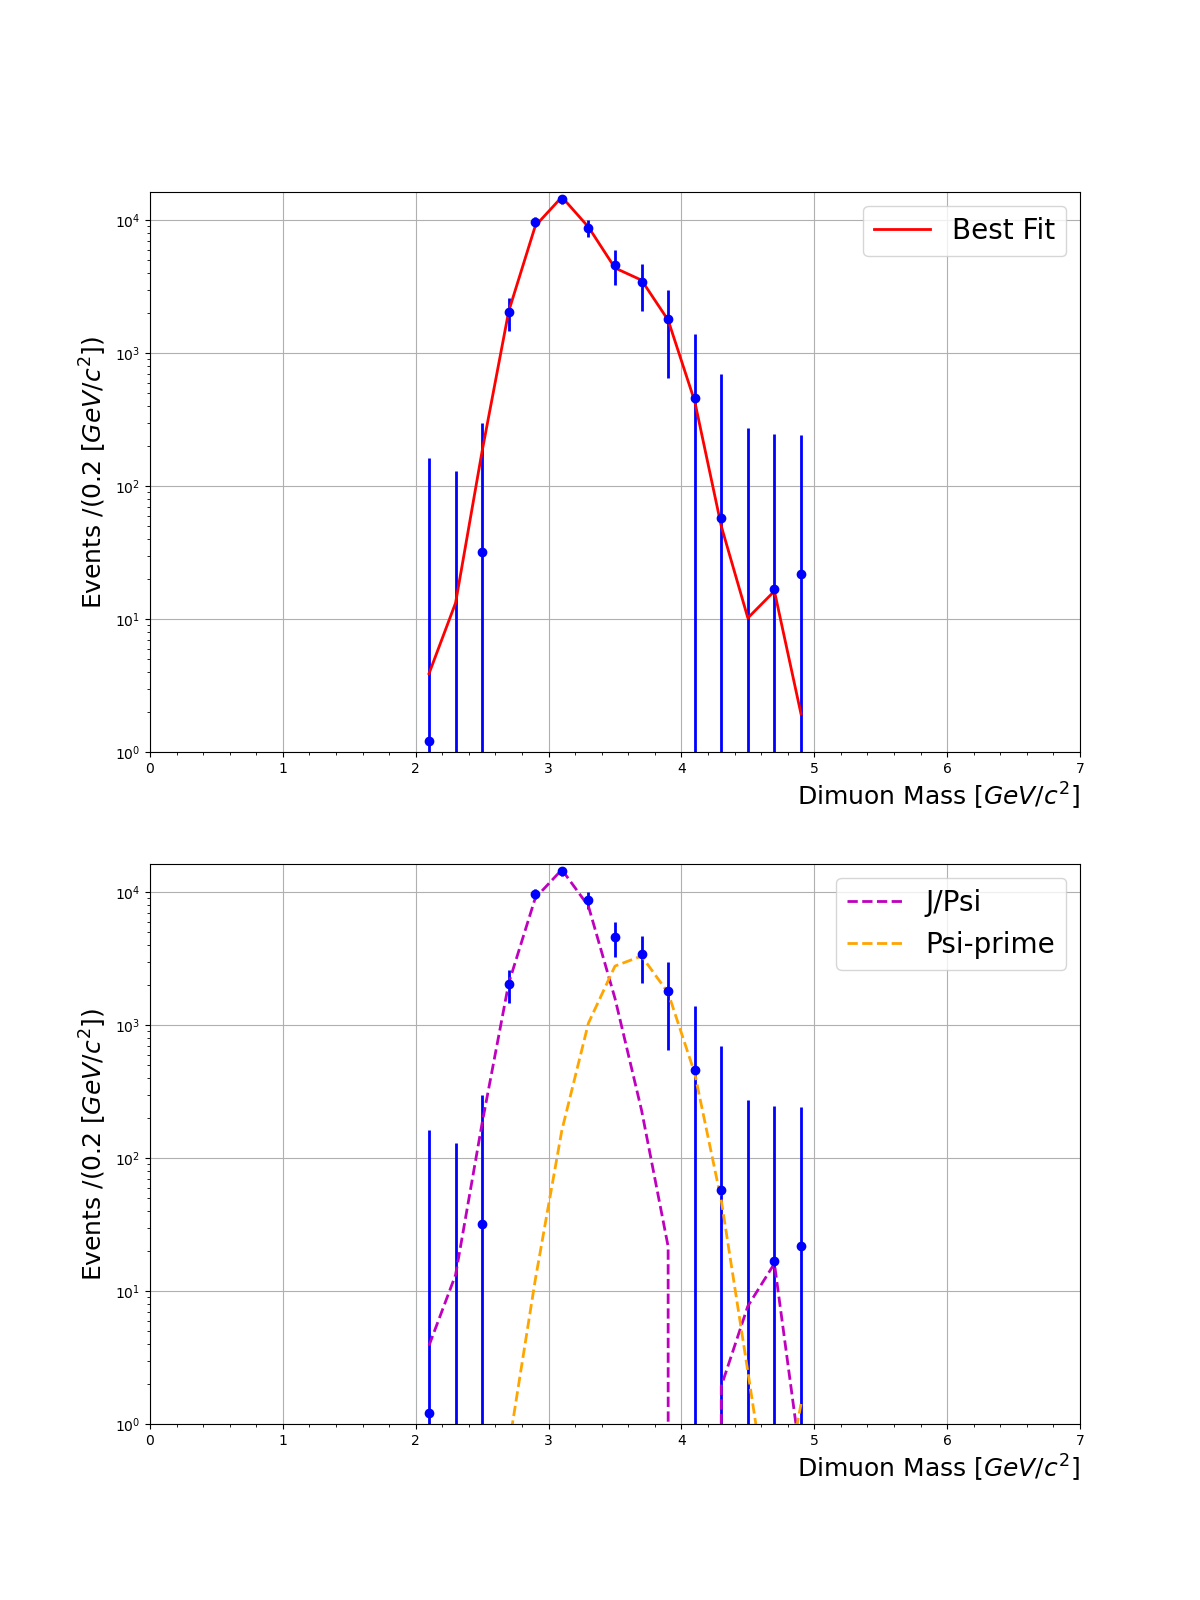

-------------------------------
Parameter    Value       Stderr
jpsi_amp  7182.01409   120.74862
psip_amp  1912.53539   161.65454


In [26]:
y1=peaks_signal[5:20]
y1_err=peaks_signal_error[5:20]

# Giving weights to Model.fit changes the array to minimize from (data-fit) to (data-fit)*weights
result_peaks = model_peaks.fit(y1,pars,x=x, weights=(1.0/(y1_err)))

#print(result_peaks.fit_report())
print(fit_report(result_peaks))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
axes[0].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
axes[0].plot(x, result_peaks.best_fit, '-', label='Best Fit',linewidth=2,color="red")
axes[0].legend()

comps = result_peaks.eval_components(x=x)
axes[1].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
axes[1].plot(x, comps['jpsi_'], '--', label='J/Psi',linewidth=2,color="m")
axes[1].plot(x, comps['psip_'], '--', label='Psi-prime',linewidth=2, color="orange")
axes[1].legend()


axes[0].grid(True)
axes[0].legend(loc='upper right')
axes[0].legend(prop={'size':20})
#axes[0].set_xticks(np.arange(xmin, xmax+1, 1.0))
axes[0].set_xticks(np.arange(0, 8, 1.0))
axes[0].xaxis.set_minor_locator( AutoMinorLocator() )
axes[0].set_xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 

axes[0].set_ylabel('Events /(0.2 $[GeV/c^2])$',
                        fontsize=18 ) 
axes[0].set_ylim(bottom=1)
axes[0].set_yscale('log')

axes[1].grid(True)
axes[1].legend(loc='upper right')
axes[1].legend(prop={'size':20})
#axes[1].set_xticks(np.arange(xmin, xmax+1, 1.0))
axes[1].set_xticks(np.arange(0, 8, 1.0))
axes[1].xaxis.set_minor_locator( AutoMinorLocator() )


axes[1].set_ylabel('Events /(0.2 $[GeV/c^2])$',
                        fontsize=18 ) 
axes[1].set_xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 
# plt.ylim(bottom=1)
# plt.yscale('log')
axes[1].set_ylim(bottom=1)
axes[1].set_yscale('log')

plt.show()

print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in result_peaks.params.items():
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

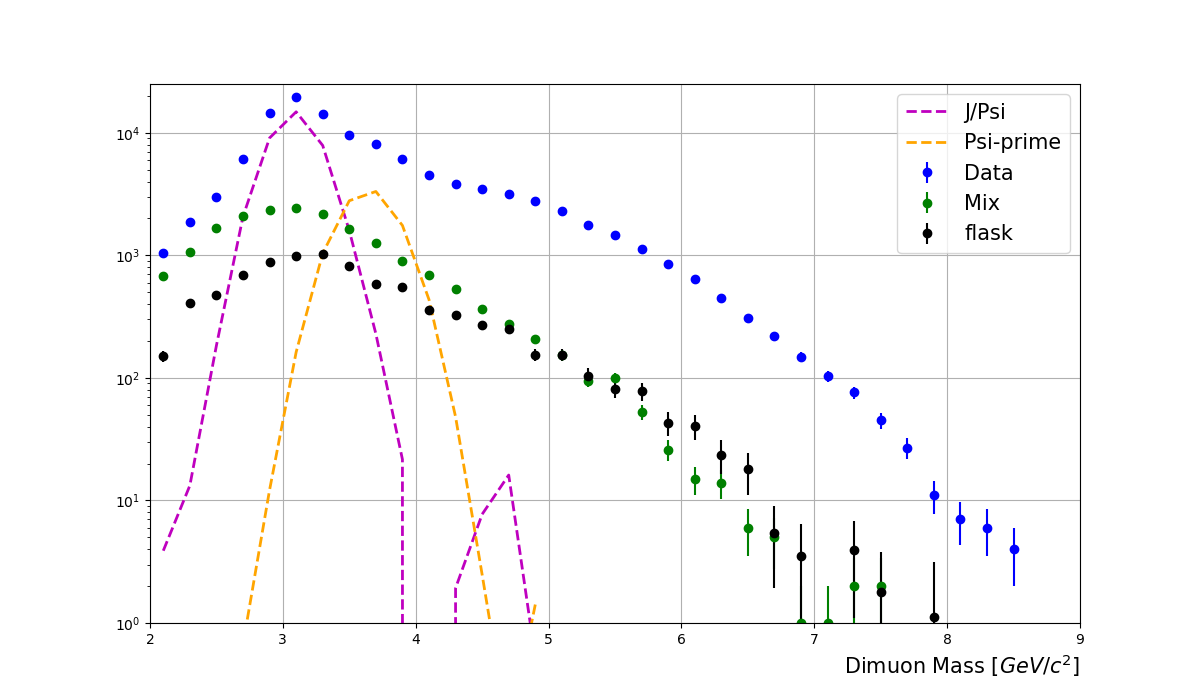

In [27]:
fig = plt.figure(figsize=(12,7))

plt.errorbar(x=bin_centres, y = data_x, yerr=data_x_errors, fmt='o', color="blue",label="Data")
plt.errorbar(x=bin_centres, y = mix_x,yerr = mix_x_errors , color="green", fmt = 'o',label="Mix")
plt.errorbar(x=bin_centres, y = flask_x, yerr=flask_x_err, fmt='o', color="black", label="flask")
#plt.plot(data[:,0],Y_pred, label="DY: Mean prediction from GPR",color='red',linestyle='--',linewidth=2)
plt.plot(x, comps['jpsi_'], '--', label='J/Psi',linewidth=2,color="m")
plt.plot(x, comps['psip_'], '--', label='Psi-prime',linewidth=2, color="orange")
plt.grid(True)
plt.legend(prop={'size':15})
plt.grid(True)
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=15 ) 
plt.ylim(top=25000)

plt.ylim(bottom=1)
plt.xlim(right=9.) #xmax is your value
plt.xlim(left=2.) #xmin is your value

plt.yscale('log')
plt.show()